In [2]:
import os
import json
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt

In diesem Notebook wurden die Grafiken für den Vergleich der Normalisierungsverfahren (mit Batch) erstellt.
Die aktuellen Versionen der hier verwendeten Funktionen und Klassen sind in den aufgesplitteten Notebooks und Skipten wie plot.ipynb oder history.ipynb zu finden.

In [3]:
class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params
        
def load_history(filename):
    with open('../histories/' + filename + '.json', 'rb') as file:
        history=pickle.load(file)
    return history

def get_best_history(histories, unit, search):
    best_history = None
    for history in histories:
        if best_history is None:
            best_history = history
        if search == 'max':
            if np.amax(best_history.history[unit]) < np.amax(history.history[unit]):
                best_history = history
        elif search == 'max':
            if np.amax(best_history.history[unit]) > np.amin(history.history[unit]):
                best_history = history
    return best_history

def average_history(histories, template_name):
    histories_num = len(histories)
    #print(histories_num)
    length = len(histories[0].history['val_loss'])
    accuracy = np.zeros(length, dtype='float32')
    recall = np.zeros(length, dtype='float32')
    precision = np.zeros(length, dtype='float32')
    loss = np.zeros(length, dtype='float32')
    val_accuracy = np.zeros(length, dtype='float32')
    val_recall = np.zeros(length, dtype='float32')
    val_precision = np.zeros(length, dtype='float32')
    val_loss = np.zeros(length, dtype='float32')
    traintime = np.array([0], dtype="float32")
    
    for history in histories:
        traintime += history.history['traintime'][0]
        for i in range(length):
            accuracy[i] += history.history['accuracy'][i]
            recall[i] += history.history['recall'][i]
            precision[i] += history.history['precision'][i]
            loss[i] += history.history['loss'][i]
            val_accuracy[i] += history.history['val_accuracy'][i]
            val_recall[i] += history.history['val_recall'][i]
            val_precision[i] += history.history['val_precision'][i]
            val_loss[i] += history.history['val_loss'][i]
            
    traintime = traintime / histories_num 
    accuracy = accuracy / histories_num
    recall = recall / histories_num
    precision = precision / histories_num
    loss = loss / histories_num
    val_accuracy = val_accuracy / histories_num
    val_recall = val_recall / histories_num
    val_precision = val_precision / histories_num
    val_loss = val_loss / histories_num
    
    avg_history = load_history(template_name)
    avg_history.history['accuracy'] = list(accuracy)
    avg_history.history['recall'] = list(recall)
    avg_history.history['precision'] = list(recall)
    avg_history.history['loss'] = list(loss)
    avg_history.history['val_accuracy'] = list(val_accuracy)
    avg_history.history['val_recall'] = list(val_recall)
    avg_history.history['val_precision'] = list(recall)
    avg_history.history['val_loss'] = list(val_loss)
    avg_history.history['traintime'] = list(traintime)
    return avg_history

def plot_graph(metric, histories, labels, loc, titel, window=None):
    plt.figure(figsize=(4.6, 3.1), dpi=90)
    for i in range(len(histories)):
        plt.plot(histories[i].history[metric], label=labels[i])
    plt.title(titel)
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    legend = plt.legend(loc=loc, prop={'size':10})
    if window is not None:
        plt.ylim(top=window[1], bottom=window[0]) # displayed area
    plt.show()

def bar_plot(histories, labels, titel, search, unit, colors, window=None, min_loss=False):
    length = len(histories)
    values = np.zeros(length)
    for i in range(length):
        if search == 'min':
            values[i] = np.amin(histories[i].history[unit])
        elif search == 'max':
            values[i] = np.amax(histories[i].history[unit])
    fig = plt.figure(figsize=(3.58,2.345), dpi=90)
    ax = fig.add_axes([0,0,1,1])
    plt.title(titel)
    plt.ylabel(unit)
    if unit == 'traintime':
        plt.ylabel('traintime in sec')
    labels = labels
    rects = ax.bar(labels, values, color=colors)
    print('values: ' + str(values))
    if window is not None:
        plt.ylim(top=window[1], bottom=window[0]) #ausschnitt der gezeigt wird, y Achse
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%g' % round(height, 3),
                ha='center', va='bottom')
    plt.show()
    
def bar_plot_loss_min(histories, labels, titel, unit, colors, window=None):
    length = len(histories)
    values = np.zeros(length)
    for i in range(length):
        min_loss_index = histories[i].history['val_loss'].index(np.amin(histories[i].history['val_loss']))
        values[i] = histories[i].history[unit][min_loss_index]
    fig = plt.figure(figsize=(3.58,2.345), dpi=90)
    ax = fig.add_axes([0,0,1,1])
    plt.title(titel)
    plt.ylabel(unit)
    if unit == 'traintime':
        plt.ylabel('traintime in sec')
    labels = labels
    rects = ax.bar(labels, values, color=colors)
    print('values: ' + str(values))
    if window is not None:
        plt.ylim(top=window[1], bottom=window[0]) #ausschnitt der gezeigt wird, y Achse
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%g' % round(height, 3),
                ha='center', va='bottom')
    plt.show()
    
def plot_directory(directory):
    histories = []
    labels = []
    for i in range(10):
        h = load_history(directory + '/' + str(i))
        print(directory + str(i) + ' - ' + str(h.history['traintime'][0]))
        #print(np.amin(h.history['val_loss']))
        histories.append(h)
        labels.append(str(i))
    plot_loss(histories,
              labels,
              directory)
    bar_plot(histories,
             labels,
             directory,
             'min',
             'val_loss')
    bar_plot(histories,
             labels,
             directory,
             'max',
             'traintime')
    
def load_histories_in_dir(directory):
    histories = []
    for i in range(num):
        h = load_history(directory + '/' + str(i))
        histories.append(h)
    return histories

def load_histories_from_folder(folder):
    histories = []
    for file in os.listdir('../histories/' + folder):
        path = '../histories/' + folder + '/' + file
        with open(path, 'rb') as file:
            h = pickle.load(file)
            histories.append(h)
    return histories

def get_histories_of_subfolders(subfolders):
    folder_hist_list = []
    for sub in subfolders:
        h = load_histories_from_folder(folder + '/' + sub)
        folder_hist_list.append(h)
    return folder_hist_list

def get_best_and_avgs(folder_hist_list):
    best = []
    avgs = []
    for folder_hist in folder_hist_list:
        best_h = get_best_history(folder_hist, 'val_accuracy', 'max')
        best.append(best_h)
        #print('best: ' + str(best_h.index(best_std)))
        avg_h = average_history(folder_hist, template_path)
        avgs.append(avg_h)
    return best, avgs


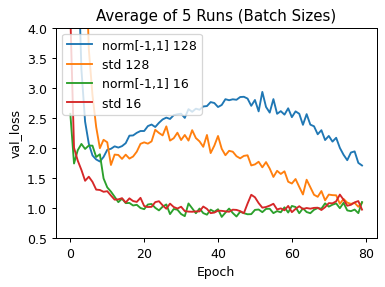

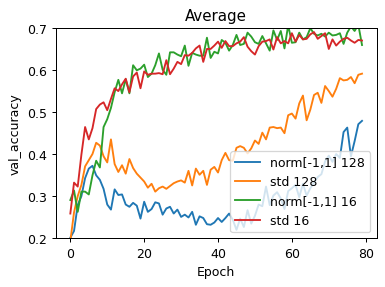

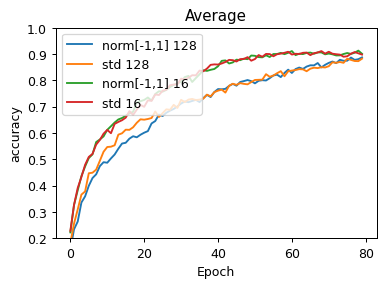

values: [0.47866663 0.59066665 0.70666671 0.68933332]


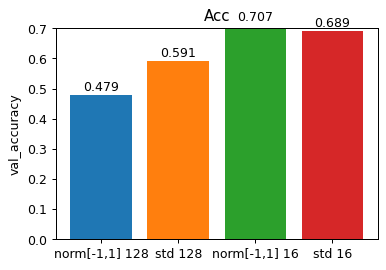

values: [1.70929778 1.02293825 0.85485899 0.91669953]


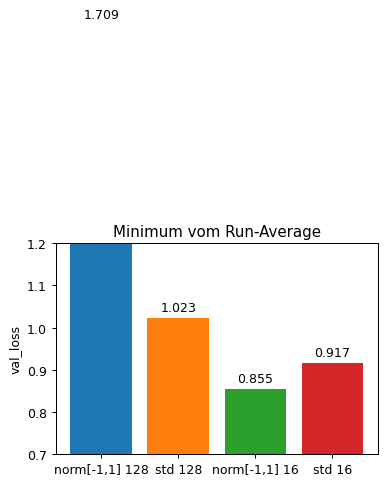

values: [0.47866663 0.588      0.67066664 0.67733335]


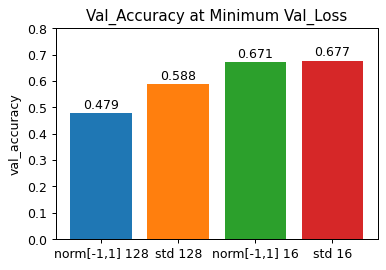

In [10]:
''' 
############### Batch test for norm ################
je 30 Runsauf VM r3
80 Epochen
'''
# define 
folder = 'test_batch_4.8'
template_path = folder + '/norm-9/norm[-1,1]_9_0'
subfolders = ['norm-128','std128','norm-16','std16']

# get best and avgs
folder_hist_list = get_histories_of_subfolders(subfolders)
best, avgs = get_best_and_avgs(folder_hist_list)

# graph settings  
labels = ['norm[-1,1] 128','std 128','norm[-1,1] 16','std 16']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
############# avg ###############
plot_graph(
    'val_loss', avgs, labels, 'upper left',
    'Average of 5 Runs (Batch Sizes)', [0.5, 4])
plot_graph(
    'val_accuracy', avgs, labels, 'lower right',
    'Average', [0.2, 0.7])
plot_graph(
    'accuracy', avgs, labels, 'upper left',
    'Average', [0.2, 1])
bar_plot(
    avgs, labels,'Acc', 'max',
    'val_accuracy', colors, [0, 0.7])
bar_plot(
    avgs, labels,'Minimum vom Run-Average', 'min',
    'val_loss', colors, [0.7, 1.2])
bar_plot_loss_min(
    avgs, labels,'Val_Accuracy at Minimum Val_Loss',
    'val_accuracy', colors, [0, 0.8])
